In [9]:
import pandas as pd

In [10]:
data = pd.read_csv('data/forex_data.csv', index_col = 'Date')


In [11]:
data.shape

(2607, 49)

In [12]:
data.head()

,AUDCAD=X,AUDCHF=X,AUDEUR=X,AUDGBP=X,AUDJPY=X,AUDNZD=X,AUDUSD=X,CADAUD=X,CADCHF=X,CADEUR=X,...,NZDAUD=X,NZDCAD=X,NZDCHF=X,NZDEUR=X,NZDGBP=X,NZDJPY=X,NZDUSD=X,USDCAD=X,USDCHF=X,USDJPY=X
Date,,,,,,,,,,,,,,,,,,,,,
2014-06-30,1.00410,0.83880,0.6900,0.5526,95.497803,1.07250,0.941708,0.99545,0.83510,0.68702,...,0.93138,0.93560,0.78160,0.6430,0.51484,88.994003,0.877578,1.06655,0.89100,101.443001
2014-07-01,1.00600,0.83580,0.6886,0.5510,95.475197,1.07540,0.942951,0.99381,0.83070,0.68415,...,0.92894,0.93493,0.77675,0.6399,0.51210,88.750000,0.876271,1.06710,0.88673,101.290001
2014-07-02,1.00927,0.84226,0.6937,0.5534,96.362297,1.08304,0.949217,0.99031,0.83423,0.68716,...,0.92270,0.93178,0.77750,0.6404,0.51090,88.970001,0.876271,1.06338,0.88748,101.540001
2014-07-03,1.00613,0.83888,0.6909,0.5496,96.063004,1.07606,0.943485,0.99342,0.83347,0.68645,...,0.92869,0.93488,0.77925,0.6419,0.51070,89.250999,0.876578,1.06666,0.88919,101.830002
2014-07-04,0.99430,0.83490,0.6870,0.5450,95.526901,1.06830,0.935016,1.00520,0.83964,0.69069,...,0.93509,0.93010,0.78100,0.6426,0.50990,89.382004,0.874661,1.06365,0.89327,102.180000


## Step 1 - Dimensionality Reduction



### Using PCA to find a compact representation for each security

- Extracts common underlying risk factors from securities’ returns;
- Produces a compact representation for each security;

Before applying PCA, the pricing data needs to be converted to returns and then normalized by subtracting the mean and dividing by the standard deviation, as follows:

Returns 

$$ R_{i, t} = \frac{P_{i,t} - P_{i,t-1}} {P_{i,t-1}} $$


Data Normalization

$$ Y_{i} =  \frac{R_{i} - \bar{R_{i}}} {\sigma_{i}} $$

Decomposition

By applying PCA, $A$ is decomposed into the resulting eigenvectors and eigenvalues. An $n$ number of eigenvectors is selected where $n$ represents the number of features to describe the transformed data. The matrix containing the eigenvalues is set as the feature vector. The final dataset is obtained by multiplying the original matrix A by the feature vector.

[0.26027606 0.1591565  0.14362117 0.10781052 0.08683108]


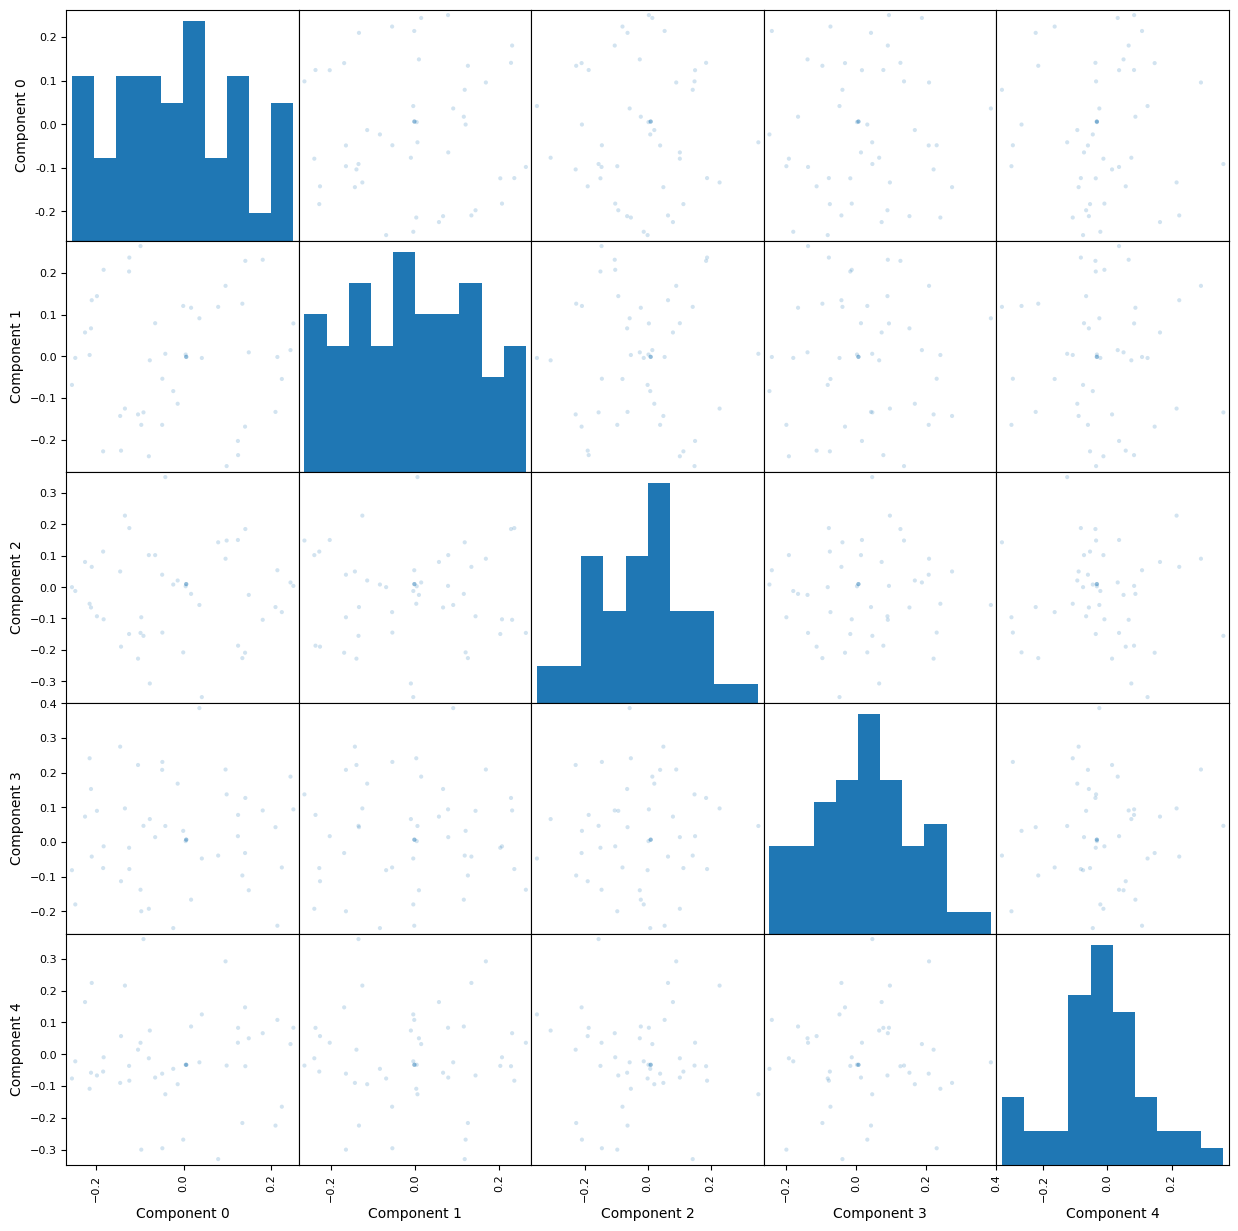

In [13]:
from libraries.clustering import Clustering

ps = Clustering(data)

# Here the first parameter is the number of features to reduce to.
pca = ps.pca(5)
print(pca.explained_variance_ratio_)

# The following will plot the feature vector from the previous method call.
ps.plot_pca_matrix()

The first 5 components explain 75.7% of the total variance.

In [14]:
pca.explained_variance_ratio_.sum()

0.7576953228075536

## Step 2 - Unsupervised Learning
### Applying OPTICS clustering algorithm

- No need to specify the number of clusters in advance;
- Robust to outliers;
- Suitable for clusters with varying density


The first method is to use the OPTICS clustering algorithm and letting the built-in automatic 
procedure to select the most suitable $\epsilon$ for each cluster. 

In [15]:
clustered_pairs, clust = ps.cluster_using_optics(min_samples=3)
ps.plot_clustering_info(method='OPTICS', n_dimensions=3)

c:\Users\Reinier\Documents\Machine Learning\Trading Algoritmico\trading_Algo\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\Reinier\Documents\Machine Learning\Trading Algoritmico\trading_Algo\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



<Figure size 1000x1000 with 0 Axes>

In [20]:
labels = clust.labels_

In [21]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print ("\nTotal custers discovered: %d" % n_clusters_)
n_noise_ = list(labels).count(-1)

print("Estimated number of noise points: %d" % n_noise_)

clustered = labels


Total custers discovered: 8
Estimated number of noise points: 18


In [22]:
clustered_series = pd.Series(data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

Text(0.5, 0, 'Currencies in Cluster')

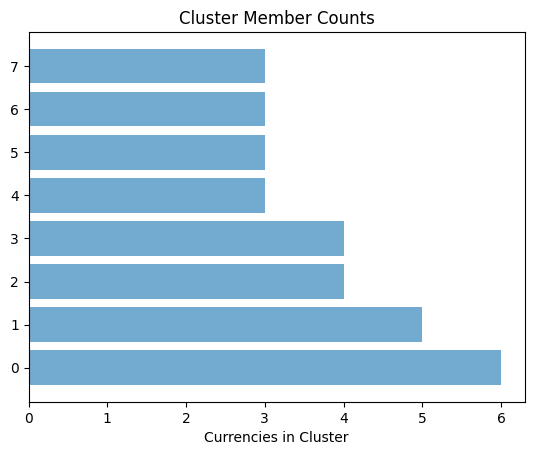

In [25]:
import matplotlib.pyplot as plt

plt.barh(
    range(len(clustered_series.value_counts())),
    clustered_series.value_counts(),
    alpha=0.625
)
plt.title('Cluster Member Counts')
plt.xlabel('Currencies in Cluster')

## Step 3 - Select Pairs
### Finding resulting pairs that pass the following set of rules

Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
- Cointegration using the Engle-Granger Test. 
- Hurst Exponent $H$: Keep the pairs with (spread) $H<0.5$ for mean-reversion. 
- Halflife: Keep the pairs with (spread) halflife in between $1$ day and $1$ year.
- Minimum number of crossing mean in a year: Keep the pairs with (spread) crossing its mean $12$ times a year.


These four criteria indicate attractive characteristics for potential tradable pairs of securities. The Engle-Granger tests the pair for cointegration. A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean. Pairs with extreme half-life values, below 1 or above 356, are excluded from the selected pairs. Extreme half-life values indicate a price series that either reverts too quickly or too slowly to be traded. Finally, the price series must cross the long-term spread mean on average at least 12 times a year.

In [8]:
# Removing duplicates from clustered pairs
clustered_pairs = list(set(clustered_pairs))

TypeError: unhashable type: 'list'

In [ ]:
clustered_pairs

[('CHFAUD=X', 'CHFCAD=X'),
 ('CADNZD=X', 'JPYCHF=X'),
 ('CADGBP=X', 'EURAUD=X'),
 ('CADGBP=X', 'EURNZD=X'),
 ('AUDNZD=X', 'USDJPY=X'),
 ('CADGBP=X', 'CHFJPY=X'),
 ('CADNZD=X', 'GBPJPY=X'),
 ('EURGBP=X', 'GBPEUR=X'),
 ('GBPAUD=X', 'GBPUSD=X'),
 ('AUDCHF=X', 'USDCHF=X'),
 ('CADNZD=X', 'CHFEUR=X'),
 ('NZDCAD=X', 'NZDUSD=X'),
 ('CADGBP=X', 'GBPEUR=X'),
 ('CADGBP=X', 'GBPJPY=X'),
 ('EURCHF=X', 'JPYCHF=X'),
 ('CHFGBP=X', 'EURCAD=X'),
 ('GBPCHF=X', 'NZDGBP=X'),
 ('EURGBP=X', 'GBPCHF=X'),
 ('CADGBP=X', 'CHFEUR=X'),
 ('AUDEUR=X', 'CADEUR=X'),
 ('AUDUSD=X', 'NZDJPY=X'),
 ('EURGBP=X', 'EURJPY=X'),
 ('AUDUSD=X', 'NZDCAD=X'),
 ('EURJPY=X', 'EURNZD=X'),
 ('EURJPY=X', 'EURUSD=X'),
 ('CADGBP=X', 'GBPCHF=X'),
 ('EURAUD=X', 'EURCHF=X'),
 ('GBPNZD=X', 'GBPUSD=X'),
 ('CHFAUD=X', 'CHFNZD=X'),
 ('CADAUD=X', 'EURCAD=X'),
 ('EURAUD=X', 'EURGBP=X'),
 ('EURAUD=X', 'EURUSD=X'),
 ('EURJPY=X', 'GBPEUR=X'),
 ('EURJPY=X', 'GBPJPY=X'),
 ('GBPJPY=X', 'NZDGBP=X'),
 ('AUDCAD=X', 'NZDJPY=X'),
 ('AUDJPY=X', 'NZDJPY=X'),
 

In [ ]:
from libraries.cointegration import CointegrationSpreadSelector

# Load data into spread selector
sp = CointegrationSpreadSelector(prices_df=data, baskets_to_filter=clustered_pairs)
                                                    

# Filtered spreads that passed the criteria by specifying hedge ratio calculation method as well as filtering conditions.
filtered_spreads = sp.select_spreads()

In [ ]:
filtered_spreads

array(['AUDCAD=X_AUDUSD=X', 'AUDCAD=X_NZDCAD=X', 'AUDCAD=X_NZDUSD=X',
       'AUDCHF=X_NZDCHF=X', 'AUDCHF=X_USDCHF=X', 'AUDEUR=X_NZDEUR=X',
       'AUDGBP=X_JPYCAD=X', 'AUDGBP=X_JPYEUR=X', 'AUDGBP=X_JPYGBP=X',
       'AUDGBP=X_JPYNZD=X', 'AUDJPY=X_NZDJPY=X', 'AUDUSD=X_NZDCAD=X',
       'AUDUSD=X_NZDUSD=X', 'CADAUD=X_CADNZD=X', 'CADAUD=X_CHFEUR=X',
       'CADAUD=X_EURAUD=X', 'CADAUD=X_EURNZD=X', 'CADAUD=X_EURUSD=X',
       'CADCHF=X_USDCHF=X', 'CADGBP=X_EURAUD=X', 'CADGBP=X_EURCAD=X',
       'CADGBP=X_EURGBP=X', 'CADGBP=X_EURUSD=X', 'CADJPY=X_USDJPY=X',
       'CADNZD=X_CHFEUR=X', 'CADNZD=X_CHFGBP=X', 'CADNZD=X_EURAUD=X',
       'CADNZD=X_EURNZD=X', 'CADNZD=X_EURUSD=X', 'CHFAUD=X_CHFNZD=X',
       'CHFEUR=X_EURNZD=X', 'EURAUD=X_EURNZD=X', 'EURAUD=X_EURUSD=X',
       'EURCAD=X_EURCHF=X', 'EURCAD=X_EURUSD=X', 'EURCHF=X_EURUSD=X',
       'EURGBP=X_EURUSD=X', 'EURNZD=X_EURUSD=X', 'GBPAUD=X_GBPNZD=X',
       'GBPAUD=X_GBPUSD=X', 'GBPCAD=X_GBPUSD=X', 'GBPNZD=X_GBPUSD=X',
       'JPYCAD=X_JPY

In [ ]:
# The module can also work with user-specified spreads to test if a spread passes cointegration selection criterion.
spread = sp.spreads_dict['NZDCAD=X_NZDUSD=X'].copy() # Let's take an arbitrary spread.
pairs_selector_custom = CointegrationSpreadSelector(prices_df=None, baskets_to_filter=None)
stats = pairs_selector_custom.generate_spread_statistics(spread, log_info=True) # log_info=True to save stats.
print(stats)

{'coint_t': -4.252621053596027, 'p_value_99%': -3.43286180083873, 'p_value_95%': -2.8626497201105283, 'p_value_90%': -2.5673607436289947, 'hurst_exponent': 0.4890790032541848, 'half_life': 95.57207466477114, 'crossovers': 61}


In [ ]:
filtered_spreads_custom = pairs_selector_custom.apply_filtering_rules(adf_cutoff_threshold=0.9, hurst_exp_threshold=0.5)
print(filtered_spreads_custom)

['NZDCAD=X_NZDUSD=X']


<Axes: xlabel='Date'>

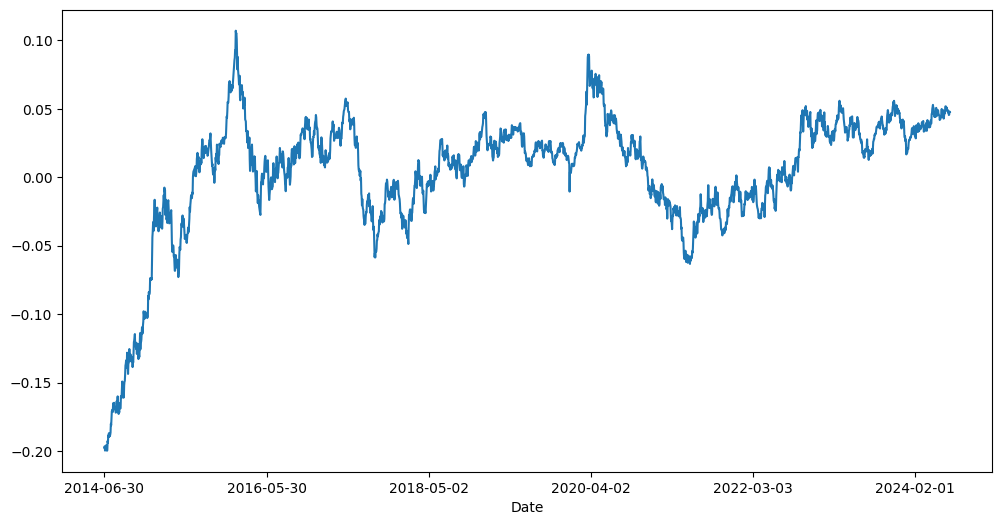

In [ ]:
# Plot one of the spreads
sp.spreads_dict['NZDCAD=X_NZDUSD=X'].plot(figsize=(12,6))

In [ ]:
# The following detailed spread statistics can be obtained
sp.selection_logs.loc[['NZDCAD=X_NZDUSD=X']].T

,NZDCAD=X_NZDUSD=X
coint_t,-4.252621
p_value_99%,-3.432862
p_value_95%,-2.86265
p_value_90%,-2.567361
hurst_exponent,0.489079
half_life,95.572075
crossovers,61
hedge_ratio,"{'NZDCAD=X': 1.0, 'NZDUSD=X': 1.2912899819771497}"
